# Fit Fors2 Spectra and Photometry with DSPS
Restricted to FORS2 galaxies with GALEX photometry

Implement this fit using this `fors2tostellarpopsynthesis` package

- Author Joseph Chevalier
- Afflilation : IJCLab/IN2P3/CNRS
- Organisation : LSST-DESC
- creation date : 2024-01-10
- last update : 2024-01-10 : Initial version

Most functions are inside the package. This notebook inherits largely from `Fors2ToStellarPopSynthesis/docs/notebooks/fitters/FitFors2ManySpecLoop.ipynb` in the `fors2tostellarpopsynthesis` package.

## Imports and general settings

In [1]:
import h5py
import pandas as pd
import numpy as np
import os
import re
import pickle 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
import collections
from collections import OrderedDict
import re
import matplotlib.gridspec as gridspec
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

import jax
import jax.numpy as jnp
from jax import vmap
import jaxopt
import optax
jax.config.update("jax_enable_x64", True)
from interpax import interp1d

In [2]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  16

In [3]:
kernel = kernels.RBF(0.5, (8000, 20000.0))
gpr = GaussianProcessRegressor(kernel=kernel ,random_state=0)

## Filters

In [4]:
from fors2tostellarpopsynthesis.filters import FilterInfo

In [5]:
FLAG_REMOVE_GALEX = False
FLAG_REMOVE_GALEX_FUV = False

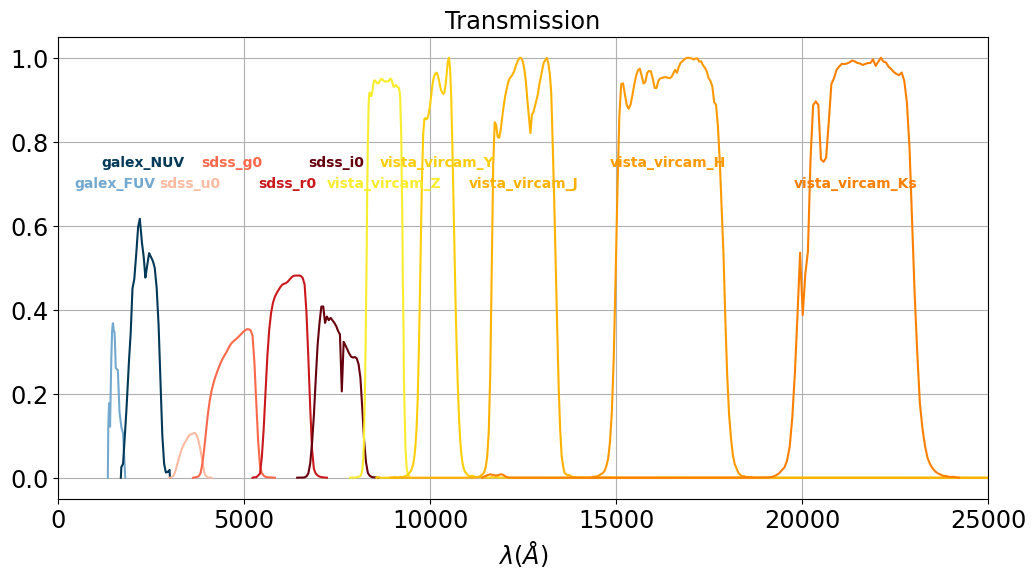

In [6]:
ps = FilterInfo()
ps.plot_transmissions()

## FORS2 and Starlight SPS extrapolation

In [7]:
from fors2tostellarpopsynthesis.fors2starlightio import Fors2DataAcess,\
                                                        SLDataAcess,\
                                                        convert_flux_torestframe,\
                                                        gpr

### Observed FORS2 data

['CLASS_STAR', 'DECJ2000', 'Delta_ZB', 'Delta_ZML', 'EXTINCTION_g', 'EXTINCTION_i', 'EXTINCTION_r', 'EXTINCTION_u', 'FLUXERR_GAAP_H', 'FLUXERR_GAAP_J', 'FLUXERR_GAAP_Ks', 'FLUXERR_GAAP_Y', 'FLUXERR_GAAP_Z', 'FLUXERR_GAAP_g', 'FLUXERR_GAAP_i', 'FLUXERR_GAAP_r', 'FLUXERR_GAAP_u', 'FLUX_GAAP_H', 'FLUX_GAAP_J', 'FLUX_GAAP_Ks', 'FLUX_GAAP_Y', 'FLUX_GAAP_Z', 'FLUX_GAAP_g', 'FLUX_GAAP_i', 'FLUX_GAAP_r', 'FLUX_GAAP_u', 'FLUX_RADIUS', 'ID', 'KIDS_TILE', 'MAGERR_GAAP_H', 'MAGERR_GAAP_J', 'MAGERR_GAAP_Ks', 'MAGERR_GAAP_Y', 'MAGERR_GAAP_Z', 'MAGERR_GAAP_g', 'MAGERR_GAAP_i', 'MAGERR_GAAP_r', 'MAGERR_GAAP_u', 'MAG_GAAP_H', 'MAG_GAAP_J', 'MAG_GAAP_Ks', 'MAG_GAAP_Y', 'MAG_GAAP_Z', 'MAG_GAAP_g', 'MAG_GAAP_i', 'MAG_GAAP_r', 'MAG_GAAP_u', 'Nsp', 'RAJ2000', 'RT', 'RV', 'Rmag', 'Z_B', 'Z_ML', 'asep_galex', 'asep_kids', 'dec', 'dec_galex', 'eRV', 'fuv_flux', 'fuv_fluxerr', 'fuv_mag', 'fuv_magerr', 'lines', 'name', 'num', 'nuv_flux', 'nuv_fluxerr', 'nuv_mag', 'nuv_magerr', 'ra', 'ra_galex', 'redshift', 'z_se

/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


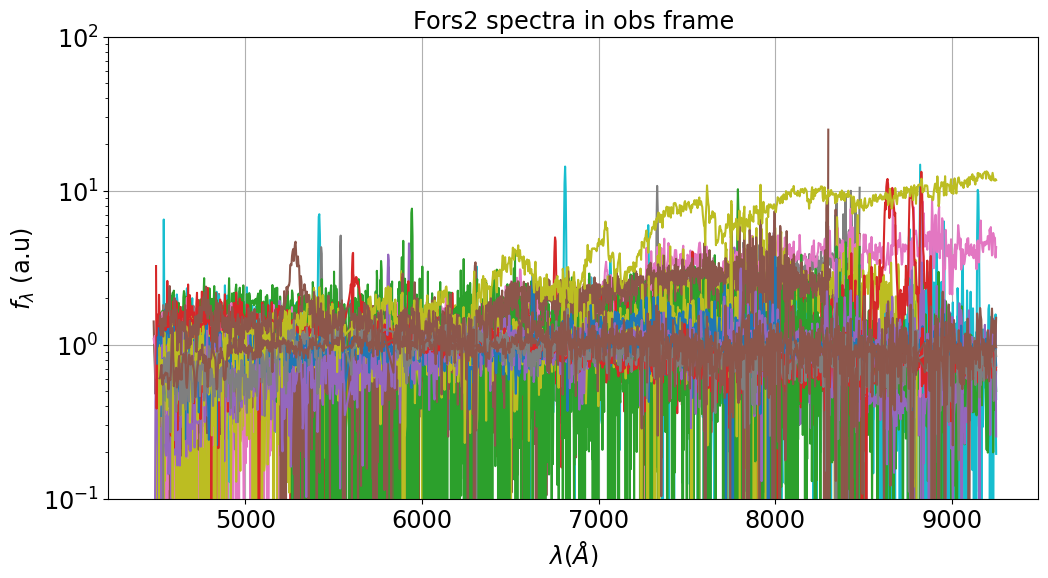

In [8]:
fors2 = Fors2DataAcess()
fors2_tags = fors2.get_list_of_groupkeys()
list_of_fors2_attributes = fors2.get_list_subgroup_keys()
print(list_of_fors2_attributes)
fors2.plot_allspectra()

### Extrapolated Starlight data

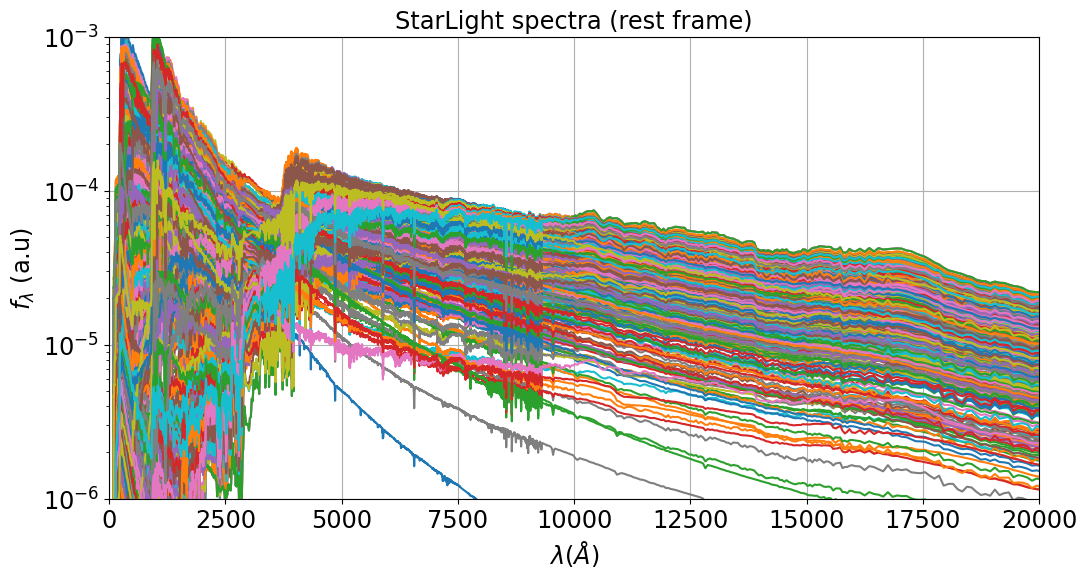

In [9]:
sl = SLDataAcess()
sl_tags = sl.get_list_of_groupkeys()
sl.plot_allspectra()

## Fitter with jaxopt

In [10]:
from fors2tostellarpopsynthesis.fitters.fitter_jaxopt import (lik_spec,\
                                                              lik_mag,\
                                                              lik_comb,\
                                                              get_infos_spec,\
                                                              get_infos_mag,\
                                                              get_infos_comb)

from fors2tostellarpopsynthesis.fitters.fitter_jaxopt import (SSP_DATA,\
                                                              mean_spectrum,\
                                                              mean_mags,\
                                                              mean_sfr,\
                                                              ssp_spectrum_fromparam)

from fors2tostellarpopsynthesis.fitters.fitter_util import (plot_fit_ssp_photometry,\
                                                            plot_fit_ssp_spectrophotometry,\
                                                            plot_fit_ssp_spectrophotometry_sl,\
                                                            plot_fit_ssp_spectroscopy,\
                                                            plot_SFH,\
                                                            rescale_photometry,\
                                                            rescale_spectroscopy,\
                                                            rescale_starlight_inrangefors2)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Parameters to fit

In [11]:
from fors2tostellarpopsynthesis.parameters import (SSPParametersFit,\
                                                   paramslist_to_dict)

## Select applicable spectra

In [12]:
selected_tags = []
for idx, tag in enumerate(fors2_tags):
    fors2_attr = fors2.getattribdata_fromgroup(tag)
    if np.isfinite(fors2_attr['fuv_mag']) and np.isfinite(fors2_attr['nuv_mag'])\
                                            and np.isfinite(fors2_attr['fuv_magerr'])\
                                            and np.isfinite(fors2_attr['nuv_magerr']) :
        selected_tags.append(tag)
len(selected_tags)

51

In [13]:
random_tags = np.random.choice(selected_tags, size=1, replace=False)

/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 6000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 6000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


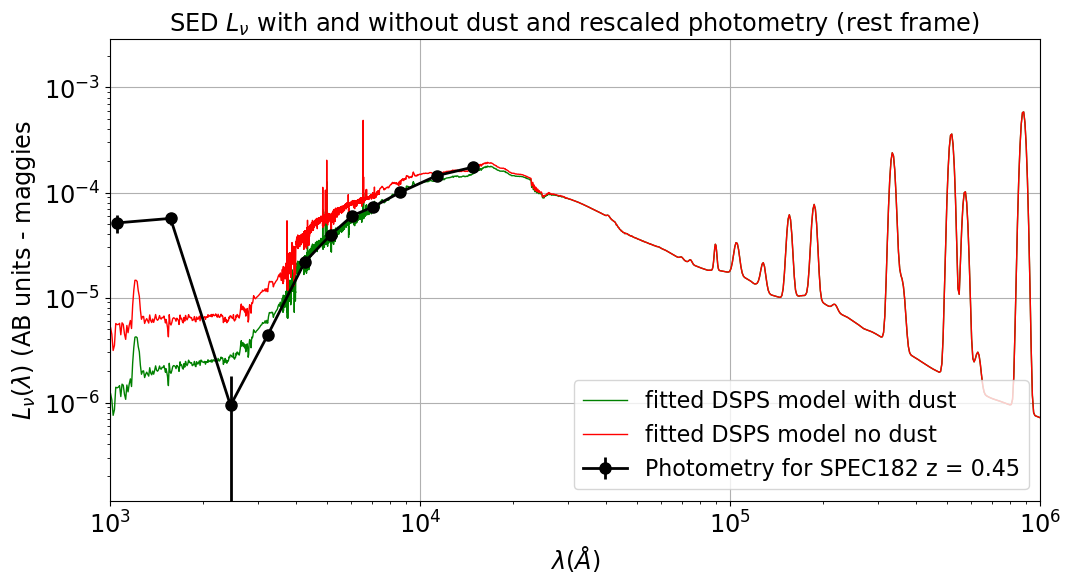

params_c: [14.          0.06        4.          1.5        12.25       -0.75
  0.75       -0.75        1.75        1.1        -0.60725    -0.91773
 -0.212307    1.11040992  3.         -0.35        1.        ] 
fun@min: 480110.14682880725 
jacob@min: [-3.67934433e+05 -1.56615047e+05 -1.98335229e+04 -1.40279548e+05
 -1.02116381e+06 -1.38909824e+06  1.89177889e+03 -1.73114623e+06
  2.32119188e+04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.72576101e-05 -2.26582900e+05  4.22345072e+05
  1.08849087e+06]
params_cm: [14.          0.06        4.          1.5        12.25       -0.75
  0.75       -0.75        1.75        1.1        -0.60725    -0.91773
 -0.212307    1.11040992  3.         -0.35        1.        ] 
fun@min: 7336.370682519388 
jacob@min: [ 1.13017681e+04  3.29410873e+03  4.16415742e+02  2.28829611e+03
  2.90911152e+04  4.03928833e+04 -1.14060802e+02  4.52383302e+04
 -9.98581087e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.2244174

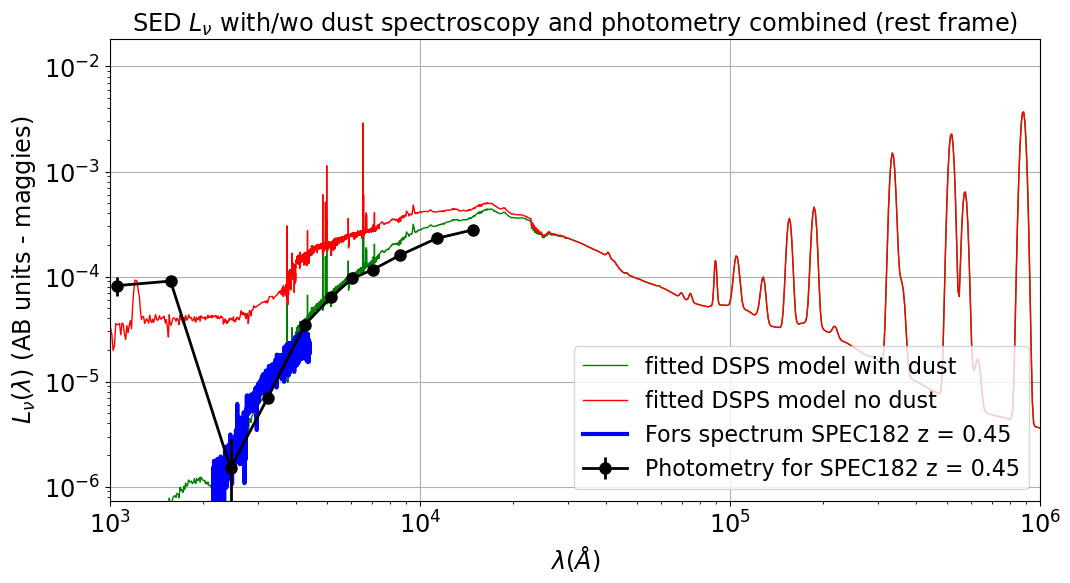

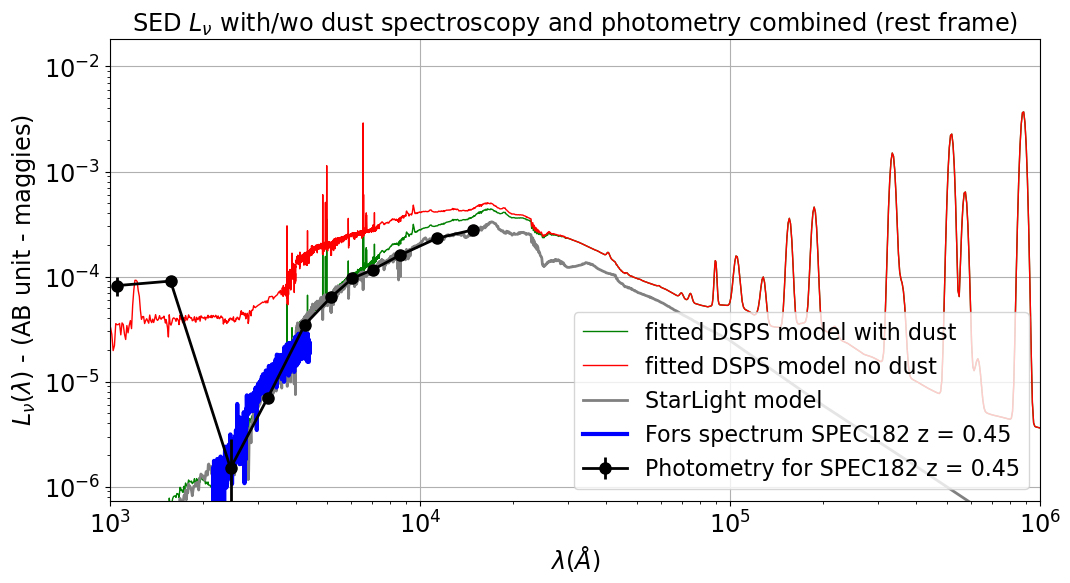

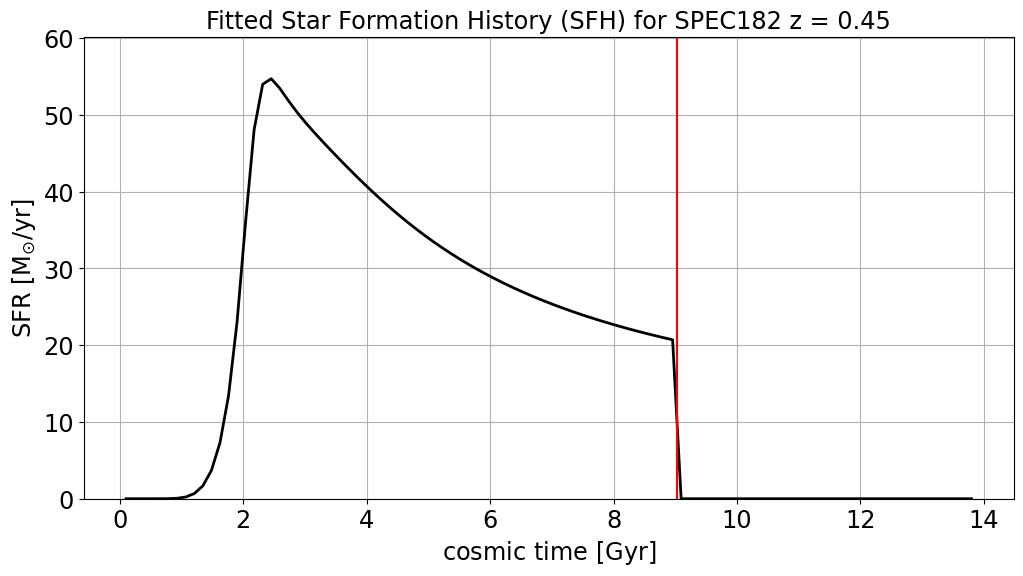

OrderedDict([('fors2name', 'SPEC182'), ('zobs', 0.44675), ('Nc', 1350), ('Ns', 1339), ('Nm', 11), ('funcmin_c', Array(480110.14682881, dtype=float64)), ('funcmin_m', Array(7336.37068252, dtype=float64)), ('funcmin_s', Array(952883.9229751, dtype=float64)), ('MAH_lgmO', Array(14., dtype=float64)), ('MAH_logtc', Array(0.06, dtype=float64)), ('MAH_early_index', Array(4., dtype=float64)), ('MAH_late_index', Array(1.5, dtype=float64)), ('MS_lgmcrit', Array(12.25, dtype=float64)), ('MS_lgy_at_mcrit', Array(-0.75, dtype=float64)), ('MS_indx_lo', Array(0.75, dtype=float64)), ('MS_indx_hi', Array(-0.75, dtype=float64)), ('MS_tau_dep', Array(1.75, dtype=float64)), ('Q_lg_qt', Array(1.1, dtype=float64)), ('Q_qlglgdt', Array(-0.60725, dtype=float64)), ('Q_lg_drop', Array(-0.91773, dtype=float64)), ('Q_lg_rejuv', Array(-0.212307, dtype=float64)), ('AV', Array(1.11040992, dtype=float64)), ('UV_BUMP', Array(3., dtype=float64)), ('PLAW_SLOPE', Array(-0.35, dtype=float64)), ('SCALEF', Array(1., dtype=f

In [14]:
for tag in random_tags:
    # extract most basic info
    selected_spectrum_number = int(re.findall("^SPEC(.*)", tag)[0])
    fors2_attr = fors2.getattribdata_fromgroup(tag)
    z_obs = fors2_attr['redshift']
    title_spec = f"{tag} z = {z_obs:.2f}"

    # retrieve magnitude data
    data_mags, data_magserr = fors2.get_photmagnitudes(tag)
    
    # get the Fors2 spectrum
    spec_obs = fors2.getspectrumcleanedemissionlines_fromgroup(tag)
    Xs = spec_obs['wl']
    Ys = spec_obs['fnu']
    EYs = spec_obs['bg']
    EYs_med = spec_obs['bg_med']
    
    # convert to restframe
    Xspec_data, Yspec_data = convert_flux_torestframe(Xs, Ys, z_obs)
    EYspec_data = EYs * (1+z_obs)
    EYspec_data_med = EYs_med * (1+z_obs)
    
    # smooth the error over the spectrum
    fit_res = gpr.fit(Xspec_data[:, None], EYspec_data)
    EYspec_data_sm = gpr.predict(Xspec_data[:, None], return_std=False)
    
    # need to increase error to decrease chi2 error
    EYspec_data_sm *= 2
    
    # parameters for fit
    p = SSPParametersFit()
    init_params = p.INIT_PARAMS
    params_min = p.PARAMS_MIN
    params_max = p.PARAMS_MAX

    # Choose filters with mags without Nan
    NoNaN_mags = np.intersect1d(np.argwhere(~np.isnan(data_mags)).flatten(),\
                                np.argwhere(~np.isnan(data_magserr)).flatten())
    
    # selected indexes for filters
    index_selected_filters = NoNaN_mags

    if FLAG_REMOVE_GALEX:
        galex_indexes = np.array([0,1])
        index_selected_filters = np.setdiff1d(NoNaN_mags, galex_indexes)
    elif FLAG_REMOVE_GALEX_FUV:
        galex_indexes = np.array([0])
        index_selected_filters = np.setdiff1d(NoNaN_mags, galex_indexes)    
        
    
    # Select filters
    XF = ps.get_2lists()
    NF = len(XF[0])
    list_wls_f_sel = []
    list_trans_f_sel = []
    list_name_f_sel = []
    list_wlmean_f_sel = []

    for index in index_selected_filters:
        list_wls_f_sel.append(XF[0][index])
        list_trans_f_sel.append(XF[1][index])
        the_filt = ps.filters_transmissionlist[index]
        the_wlmean = the_filt.wave_mean
        list_wlmean_f_sel.append(the_wlmean)
        list_name_f_sel.append(ps.filters_namelist[index])
    
    list_wlmean_f_sel = jnp.array(list_wlmean_f_sel)
    Xf_sel = (list_wls_f_sel, list_trans_f_sel)
    
    # get the magnitudes and magnitude errors
    data_selected_mags =  jnp.array(data_mags[index_selected_filters])
    data_selected_magserr = jnp.array(data_magserr[index_selected_filters])
    
    #fit with magnitudes only
    lbfgsb = jaxopt.ScipyBoundedMinimize(fun = lik_mag, method = "L-BFGS-B")
    res_m = lbfgsb.run(init_params,\
                       bounds=(params_min, params_max),\
                       xf = Xf_sel,\
                       mags_measured = data_selected_mags,\
                       sigma_mag_obs = data_selected_magserr,\
                       z_obs = z_obs)
    params_m, fun_min_m, jacob_min_m, inv_hessian_min_m = get_infos_mag(res_m,\
                                                                        lik_mag,\
                                                                        xf = Xf_sel,\
                                                                        mgs = data_selected_mags,\
                                                                        mgse = data_selected_magserr,\
                                                                        z_obs=z_obs)
    #print("params:",params_m,"\nfun@min:",fun_min_m,"\njacob@min:",jacob_min_m)
    
    # Convert fitted parameters into a dictionnary
    dict_params_m = paramslist_to_dict(params_m, p.PARAM_NAMES_FLAT) 
    
    # rescale photometry datapoints
    xphot_rest, yphot_rest, eyphot_rest, factor = rescale_photometry(dict_params_m,\
                                                                     list_wlmean_f_sel,\
                                                                     data_selected_mags,\
                                                                     data_selected_magserr,\
                                                                     z_obs)
    
    # plot model with photometry
    plot_fit_ssp_photometry(dict_params_m,\
                            list_wlmean_f_sel,\
                            data_selected_mags,\
                            data_selected_magserr,\
                            z_obs,\
                            subtit = title_spec,\
                            ax=None)
    
    #rescale Fors2 spectroscopy
    Xspec_data_rest, Yspec_data_rest, EYspec_data_rest, factor = rescale_spectroscopy(dict_params_m,\
                                                                                      Xspec_data,\
                                                                                      Yspec_data,\
                                                                                      EYspec_data,\
                                                                                      z_obs)
    '''
    # fit spectroscopy
    lbfgsb = jaxopt.ScipyBoundedMinimize(fun = lik_spec, method = "L-BFGS-B")
    res_s = lbfgsb.run(init_params,\
                       bounds = (params_min, params_max),\
                       wls = Xspec_data_rest,\
                       F = Yspec_data_rest,\
                       sigma_obs = EYspec_data_rest,\
                       z_obs = z_obs)
    params_s, fun_min_s, jacob_min_s, inv_hessian_min_s = get_infos_spec(res_s,\
                                                                         lik_spec,\
                                                                         wls = Xspec_data,\
                                                                         F = Yspec_data,\
                                                                         eF = EYspec_data,\
                                                                         z_obs = z_obs)
    #print("params:",params_s,"\nfun@min:",fun_min_s,"\njacob@min:",jacob_min_s)

    # Convert fitted parameters with spectroscopy into a dictionnary
    dict_params_s = paramslist_to_dict( params_s,p.PARAM_NAMES_FLAT) 
    
    # plot fit for spectroscopy only
    plot_fit_ssp_spectroscopy(dict_params_s,\
                              Xspec_data_rest,\
                              Yspec_data_rest,\
                              EYspec_data_rest,\
                              z_obs,\
                              subtit = title_spec)
    '''
    
    # combining spectro and photometry
    Xc = [Xspec_data_rest, Xf_sel]
    Yc = [Yspec_data_rest, data_selected_mags]
    EYc = [EYspec_data_rest, data_selected_magserr]
    weight_spec = 0.5
    Ns = len(Yspec_data_rest)
    Nm = len(data_selected_mags)
    Nc = Ns+Nm
    
    # do the combined fit
    lbfgsb = jaxopt.ScipyBoundedMinimize(fun = lik_comb, method = "L-BFGS-B")
    res_c = lbfgsb.run(init_params,\
                       bounds = (params_min, params_max),\
                       xc = Xc,\
                       datac = Yc,\
                       sigmac = EYc,\
                       z_obs = z_obs,\
                       weight = weight_spec)
    params_c, fun_min_c, jacob_min_c, inv_hessian_min_c = get_infos_comb(res_c,\
                                                                         lik_comb,\
                                                                         xc = Xc,\
                                                                         datac = Yc,\
                                                                         sigmac = EYc,\
                                                                         z_obs = z_obs,\
                                                                         weight = weight_spec)
    params_cm, fun_min_cm, jacob_min_cm, inv_hessian_min_cm  = get_infos_mag(res_c,\
                                                                             lik_mag,\
                                                                             xf = Xf_sel,\
                                                                             mgs = data_selected_mags,\
                                                                             mgse = data_selected_magserr,\
                                                                             z_obs = z_obs)
    params_cs, fun_min_cs, jacob_min_cs, inv_hessian_min_cs = get_infos_spec(res_c,\
                                                                             lik_spec,\
                                                                             wls = Xspec_data_rest,\
                                                                             F = Yspec_data_rest,\
                                                                             eF = EYspec_data_rest,\
                                                                             z_obs = z_obs)
    print("params_c:", params_c, "\nfun@min:", fun_min_c, "\njacob@min:", jacob_min_c) #,"\n invH@min:",inv_hessian_min_c)
    print("params_cm:", params_cm, "\nfun@min:", fun_min_cm, "\njacob@min:", jacob_min_cm)
    print("params_cs:", params_cs, "\nfun@min:", fun_min_cs, "\njacob@min:", jacob_min_cs)

    #save to dictionary
    dict_out = OrderedDict()
    dict_out["fors2name"] = tag
    dict_out["zobs"] = z_obs
    dict_out["Nc"] = Nc
    dict_out["Ns"] = Ns
    dict_out["Nm"] = Nm
    dict_out["funcmin_c"] = fun_min_c
    dict_out["funcmin_m"] = fun_min_cm
    dict_out["funcmin_s"] = fun_min_cs
       
    # convert into a dictionnary
    dict_params_c = paramslist_to_dict(params_c, p.PARAM_NAMES_FLAT) 
    dict_out.update(dict_params_c)
        
    # plot the combined fit
    plot_fit_ssp_spectrophotometry(dict_params_c,\
                                   Xspec_data_rest,\
                                   Yspec_data_rest,\
                                   EYspec_data_rest,\
                                   xphot_rest,\
                                   yphot_rest,\
                                   eyphot_rest,\
                                   z_obs = z_obs,\
                                   subtit = title_spec )
    
    #load starlight spectrum
    dict_sl = sl.getspectrum_fromgroup(tag)
    
    # rescale starlight spectrum
    w_sl, fnu_sl, _ = rescale_starlight_inrangefors2(dict_sl["wl"],\
                                                     dict_sl["fnu"],\
                                                     Xspec_data_rest,\
                                                     Yspec_data_rest)
    
    # plot starlight
    plot_fit_ssp_spectrophotometry_sl(dict_params_c,\
                                      Xspec_data_rest,\
                                      Yspec_data_rest,\
                                      EYspec_data_rest,\
                                      xphot_rest,\
                                      yphot_rest,\
                                      eyphot_rest,\
                                      w_sl,\
                                      fnu_sl,\
                                      z_obs = z_obs,\
                                      subtit = title_spec)
    
    # plot SFR
    plot_SFH(dict_params_c, z_obs, subtit = title_spec, ax=None)
    
    #save parameters
    filename_params = f"fitparams_{tag}_galex.pickle"
    with open(filename_params, 'wb') as f:
        print(dict_out)
        pickle.dump(dict_out, f)

Photometry in UV is not consistant with the extrapolated spectrum. Further checks are needed.
A good start would be to actually triple-check the correspondance between FORS2 spectra and sources of photometry.

## Metallicity

In [15]:
from dsps.cosmology import DEFAULT_COSMOLOGY, age_at_z

# metallicity
gal_lgmet = -2.0 # log10(Z)
gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function

# need age of universe when the light was emitted
t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument

In [16]:
tau_arr = t_obs-jnp.power(10, SSP_DATA.ssp_lg_age_gyr)
tau_arr

Array([  9.02787257,   9.02786037,   9.02784668,   9.02783131,
         9.02781408,   9.02779474,   9.02777304,   9.0277487 ,
         9.02772138,   9.02769073,   9.02765634,   9.02761775,
         9.02757446,   9.02752588,   9.02747138,   9.02741023,
         9.02734161,   9.02726462,   9.02717824,   9.02708132,
         9.02697257,   9.02685055,   9.02671364,   9.02656003,
         9.02638767,   9.02619429,   9.02597731,   9.02573385,
         9.02546068,   9.02515419,   9.02481029,   9.02442443,
         9.0239915 ,   9.02350573,   9.0229607 ,   9.02234915,
         9.02166299,   9.02089311,   9.02002929,   9.01906006,
         9.01797257,   9.01675238,   9.01538331,   9.01384719,
         9.01212364,   9.01018977,   9.00801994,   9.00558536,
         9.0028537 ,   8.99978874,   8.99634979,   8.99249123,
         8.98816185,   8.98330421,   8.97785384,   8.97173844,
         8.96487683,   8.95717799,   8.94853974,   8.93884747,
         8.92797257,   8.91577072,   8.90208003,   8.88

In [17]:
from dsps.utils import triweight_gaussian

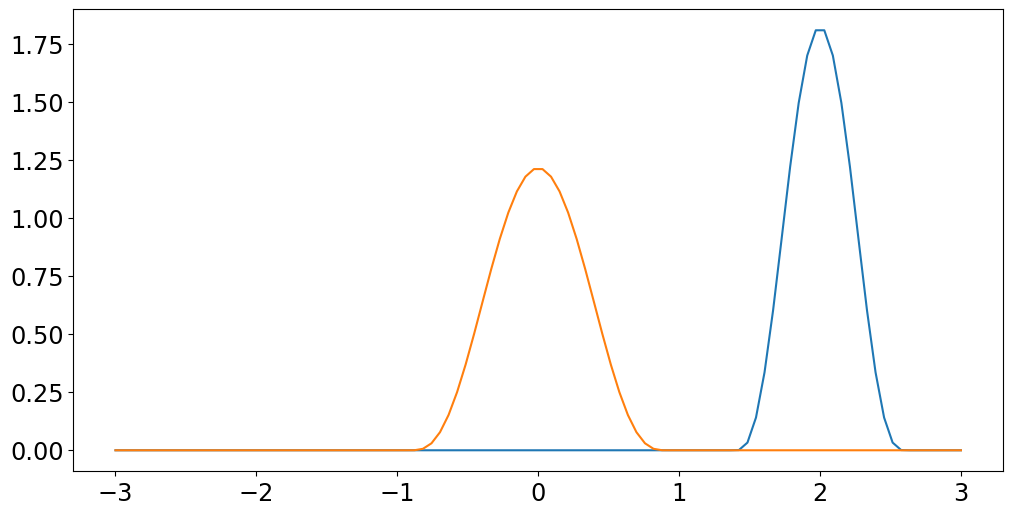

In [18]:
metals = jnp.linspace(-3, 3, 100)
plt.plot(metals, triweight_gaussian(metals, 2., 0.2))
plt.plot(metals, triweight_gaussian(metals, 0., 0.3))

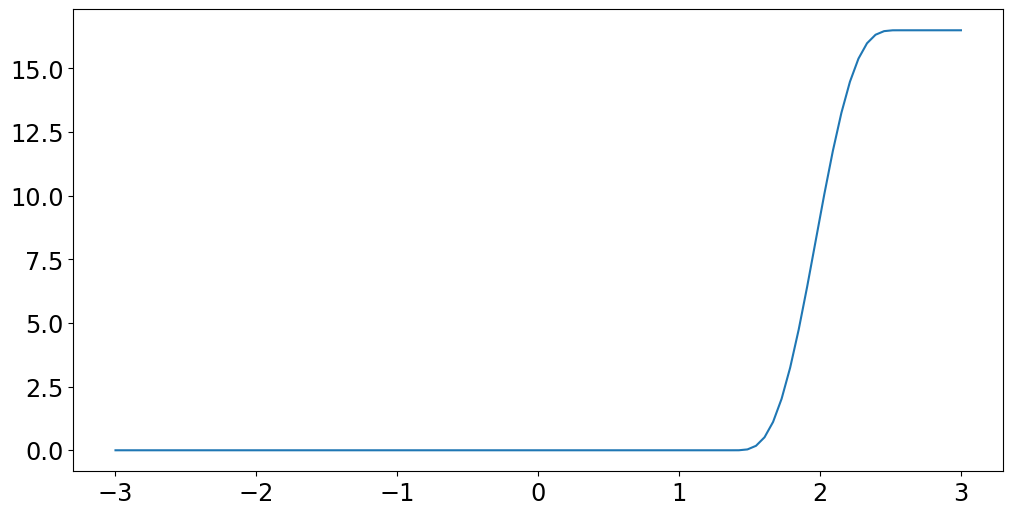

In [19]:
mdf = triweight_gaussian(metals, 2., 0.2)
cum_twg = jnp.cumsum(mdf)
plt.plot(metals, cum_twg)

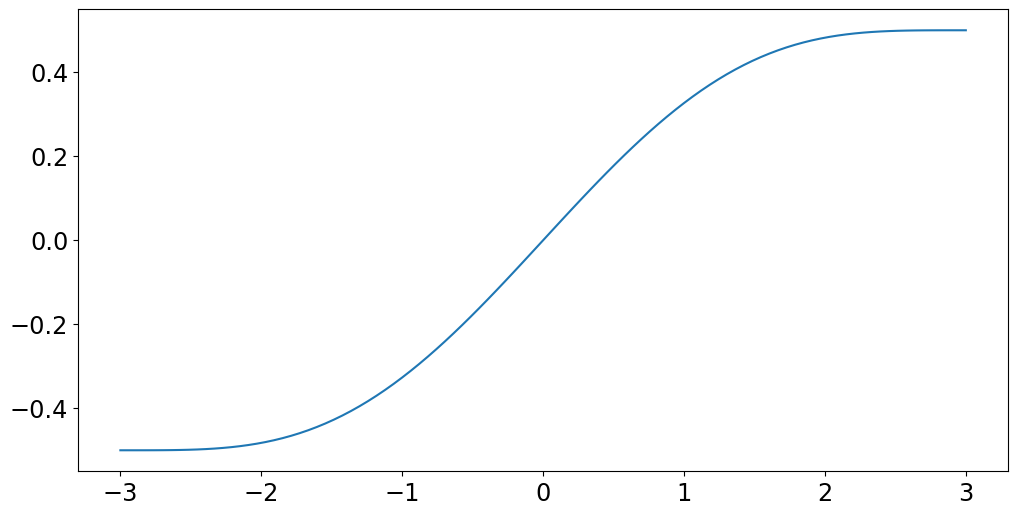

In [20]:
zzz = jnp.linspace(-3, 3, 100)
plt.plot(zzz, zzz*35/96 - zzz**3 * 35/864 + zzz**5 * 7/2592 - zzz**7 * 5/69984)

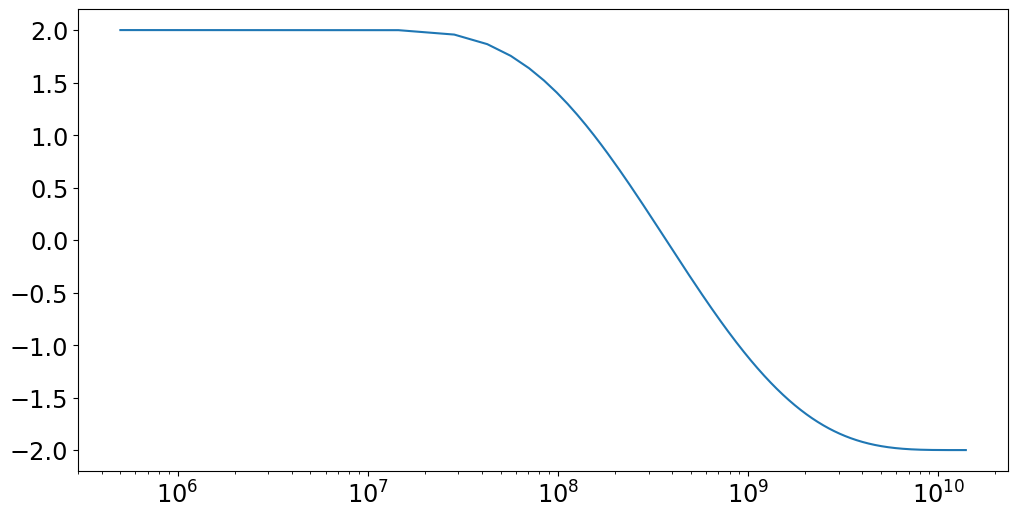

In [21]:
mu_old, mu_young = -2, 2

tau_yrs = tau_arr * 10**9
t_avg = jnp.average(tau_arr)
t_sig = jnp.abs(jnp.max(tau_arr)-jnp.min(tau_arr))/6

def mu_tau_triweight_cumulative(age, mu_old, mu_young):
    mu_mid = 0.5*(jnp.log10(13.8) + jnp.log10(0.01))
    sigma_mu = jnp.abs(jnp.log10(13.8)-jnp.log10(0.01))/6
    z = (jnp.log10(age)-mu_mid)/sigma_mu
    p_z = (mu_young+mu_old)/2 - (mu_young-mu_old)*(z*35/96 - z**3 * 35/864 + z**5 * 7/2592 - z**7 * 5/69984)
    p_z = jnp.where((z < -3), mu_young, p_z)
    p_z = jnp.where((z > 3), mu_old, p_z)
    return p_z

def mu_tau_triweight(age, mu_old, mu_young):
    mu_mid = 0.5*(jnp.log10(13.8) + jnp.log10(0.001))
    sigma_mu = jnp.abs(jnp.log10(13.8)-jnp.log10(0.001))/6
    z = (jnp.log10(age)-mu_mid)/sigma_mu
    _msk = (z < -3) | (z > 3)
    p_z = 35 * jnp.power(1 - jnp.power(z/3, 2), 3) / 96
    return jnp.where(_msk, 0, p_z)

tau_arr = jnp.linspace(0.0005, 14, 1000)

t_kernel = mu_tau_triweight_cumulative(tau_arr, mu_old, mu_young)
plt.plot(tau_arr * 10**9, t_kernel)
plt.xscale('log')

In [22]:
from dsps import calc_rest_sed_sfh_table_lognormal_mdf

def calc_rest_sed_sfh_table_agedependant_mdf(gal_t_table, gal_sfr_table,\
                                          mu_old, mu_young, gal_lgmet_scatter,\
                                          ssp_lgmet,\
                                          ssp_lg_age_gyr,\
                                          ssp_flux,\
                                          t_obs):
    _tau = t_obs-10**ssp_lg_age_gyr # tau_age in  Gyr
    gal_lg_met = mu_tau_triweight_cumulative(_tau, mu_old, mu_young) # logZ function of age
    
    # Finally : use the DSPS lognormal-MDF function to generate the SED
    return calc_rest_sed_sfh_table_lognormal_mdf(gal_t_table, gal_sfr_table,\
                                                 gal_lgmet, gal_lgmet_scatter,\
                                                 ssp_lgmet,\
                                                 ssp_lg_age_gyr,\
                                                 ssp_flux,\
                                                 t_obs)


"""
"""
from dsps.sed.metallicity_weights import calc_lgmet_weights_from_lognormal_mdf
from dsps.sed.ssp_weights import SSPWeights
from dsps.sed.stellar_age_weights import calc_age_weights_from_sfh_table
from dsps.sed.stellar_sed import RestSED
from dsps.utils import _tw_sigmoid, cumulative_mstar_formed
from jax import jit as jjit
from jax import numpy as jnp
from jax import vmap

LGAGE_CRIT_YR, LGAGE_CRIT_H = 8.0, 1.0

@jjit
def _age_correlated_met_weights_kern(
    lg_ages_gyr, lgmet_young, lgmet_old, lgmet_scatter, ssp_lgmet
):
    lg_ages_yr = lg_ages_gyr + 9
    lgmet = _tw_sigmoid(lg_ages_yr, LGAGE_CRIT_YR, LGAGE_CRIT_H, lgmet_young, lgmet_old)
    lgmet_weights = calc_lgmet_weights_from_lognormal_mdf(
        lgmet, lgmet_scatter, ssp_lgmet
    )
    return lgmet_weights


_a = (0, None, None, None, None)
_age_correlated_met_weights_vmap = jjit(
    vmap(_age_correlated_met_weights_kern, in_axes=_a)
)


@jjit
def _get_age_correlated_met_weights(
    lg_ages_gyr, lgmet_young, lgmet_old, lgmet_scatter, ssp_lgmet
):
    lgmet_weights = _age_correlated_met_weights_vmap(
        lg_ages_gyr, lgmet_young, lgmet_old, lgmet_scatter, ssp_lgmet
    )
    return lgmet_weights.T


@jjit
def calc_ssp_weights_sfh_table_lognormal_mdf_agedep(
    gal_t_table,
    gal_sfh_table,
    lgmet_young,
    lgmet_old,
    lgmet_scatter,
    ssp_lgmet,
    ssp_lg_age_gyr,
    t_obs,
):
    """Calculate SSP weights of a tabulated SFH and a lognormal MDF

    Parameters
    ----------
    gal_t_table : ndarray of shape (n_t, )
        Age of the universe in Gyr when the galaxy SFH is tabulated

    gal_sfr_table : ndarray of shape (n_t, )
        Tabulation of the galaxy SFH in Msun/yr at the times gal_t_table

    gal_lgmet : float
        log10(Z), center of the lognormal metallicity distribution function

    gal_lgmet_scatter : float
        lognormal scatter about gal_lgmet

    ssp_lgmet : ndarray of shape (n_ages, )
        Array of log10(Z) of the SSP templates

    ssp_lg_age_gyr : ndarray of shape (n_ages, )
        Array of log10(age/Gyr) of the SSP templates

    t_obs : float
        Age of the universe in Gyr at the time the galaxy is observed

    Returns
    -------
    SSPWeights : namedtuple with the following entries:

        weights : ndarray of shape (n_met, n_ages)
            SSP weights of the joint distribution of stellar age and metallicity

        lgmet_weights : ndarray of shape (n_met, )
            SSP weights of the distribution of stellar metallicity

        age_weights : ndarray of shape (n_ages, )
            SSP weights of the distribution of stellar age

    """
    age_weights = calc_age_weights_from_sfh_table(
        gal_t_table, gal_sfh_table, ssp_lg_age_gyr, t_obs
    )

    lgmet_weights = _get_age_correlated_met_weights(
        ssp_lg_age_gyr, lgmet_young, lgmet_old, lgmet_scatter, ssp_lgmet
    )
    weights = lgmet_weights * age_weights.reshape((1, -1))

    return SSPWeights(weights, lgmet_weights, age_weights)


@jjit
def calc_rest_sed_sfh_table_lognormal_mdf_agedep(
    gal_t_table,
    gal_sfr_table,
    gal_lgmet_young,
    gal_lgmet_old,
    gal_lgmet_scatter,
    ssp_lgmet,
    ssp_lg_age_gyr,
    ssp_flux,
    t_obs,
):
    """
    Calculate the SED of a galaxy defined by input tables of SFH and
    a lognormal metallicity distribution function

    Parameters
    ----------
    gal_t_table : ndarray of shape (n_t, )
        Age of the universe in Gyr at which the input galaxy SFH has been tabulated

    gal_sfr_table : ndarray of shape (n_t, )
        Star formation history in Msun/yr evaluated at the input gal_t_table

    gal_lgmet_young : float
        log10(Z) of young stars in the galaxy

    gal_lgmet_old : float
        log10(Z) of old stars in the galaxy

    gal_lgmet_scatter : float
        Lognormal scatter in metallicity

    ssp_lgmet : ndarray of shape (n_met, )
        Array of log10(Z) of the SSP templates

    ssp_lg_age_gyr : ndarray of shape (n_ages, )
        Array of log10(age/Gyr) of the SSP templates

    ssp_flux : ndarray of shape (n_met, n_ages, n_wave)
        SED of the SSP in units of Lsun/Hz/Msun

    t_obs : float
        Age of the universe in Gyr at the time the galaxy is observed

    Returns
    -------
    RestSED : namedtuple with the following entries:

        rest_sed : ndarray of shape (n_wave, )
            Restframe SED of the galaxy in units of Lsun/Hz

        weights : ndarray of shape (n_met, n_ages, 1)
            SSP weights of the joint distribution of stellar age and metallicity

        lgmet_weights : ndarray of shape (n_met, )
            SSP weights of the distribution of stellar metallicity

        age_weights : ndarray of shape (n_ages, )
            SSP weights of the distribution of stellar age

    """
    ssp_weights = calc_ssp_weights_sfh_table_lognormal_mdf_agedep(
        gal_t_table,
        gal_sfr_table,
        gal_lgmet_young,
        gal_lgmet_old,
        gal_lgmet_scatter,
        ssp_lgmet,
        ssp_lg_age_gyr,
        t_obs,
    )
    weights, lgmet_weights, age_weights = ssp_weights
    n_met, n_ages = weights.shape
    sed_unit_mstar = jnp.sum(
        ssp_flux * weights.reshape((n_met, n_ages, 1)), axis=(0, 1)
    )

    gal_mstar_table = cumulative_mstar_formed(gal_t_table, gal_sfr_table)
    gal_logsm_table = jnp.log10(gal_mstar_table)
    logsm_obs = jnp.interp(jnp.log10(t_obs), jnp.log10(gal_t_table), gal_logsm_table)
    mstar_obs = 10**logsm_obs
    rest_sed = sed_unit_mstar * mstar_obs
    return RestSED(rest_sed, weights, lgmet_weights, age_weights)

## Modify Sylvie's function to include age-dependant metallicity

In [23]:
import copy
import os

import jax
import jax.numpy as jnp
import jax.scipy as jsc
import jaxopt
import numpy as np
import optax
from interpax import interp1d
from jax import grad, hessian, jacfwd, jacrev, jit, vmap

jax.config.update("jax_enable_x64", True)

from diffstar import sfh_singlegal
from dsps import (calc_obs_mag, calc_rest_mag,
                  calc_rest_sed_sfh_table_lognormal_mdf,
                  calc_rest_sed_sfh_table_met_table, load_ssp_templates)
from dsps.cosmology import DEFAULT_COSMOLOGY, age_at_z
from dsps.dust.att_curves import (RV_C00, _frac_transmission_from_k_lambda,
                                  sbl18_k_lambda)

FILENAME_SSP_DATA = 'data/tempdata.h5'
FULLFILENAME_SSP_DATA = os.path.join('Fors2ToStellarPopSynthesis', 'src', 'fors2tostellarpopsynthesis', 'fitters', FILENAME_SSP_DATA)
SSP_DATA = load_ssp_templates(fn=FULLFILENAME_SSP_DATA)


TODAY_GYR = 13.8

@jit
def ssp_spectrum_fromparam_agedependant(params,z_obs):
    """ Return the SED of SSP DSPS with original wavelength range wihout and with dust

    :param params: parameters for the fit
    :type params: dictionnary of parameters

    :param z_obs: redshift at which the model SSP should be calculated
    :type z_obs: float

    :return: the wavelength and the spectrum with dust and no dust
    :rtype: float

    """

    # decode the parameters
    MAH_lgmO = params["MAH_lgmO"]
    MAH_logtc = params["MAH_logtc"]
    MAH_early_index = params["MAH_early_index"]
    MAH_late_index = params["MAH_late_index"]
    list_param_mah = [MAH_lgmO,MAH_logtc,MAH_early_index,MAH_late_index]

    MS_lgmcrit = params["MS_lgmcrit"]
    MS_lgy_at_mcrit = params["MS_lgy_at_mcrit"]
    MS_indx_lo = params["MS_indx_lo"]
    MS_indx_hi = params["MS_indx_hi"]
    MS_tau_dep = params["MS_tau_dep"]
    list_param_ms = [MS_lgmcrit,MS_lgy_at_mcrit,MS_indx_lo,MS_indx_hi,MS_tau_dep]

    Q_lg_qt = params["Q_lg_qt"]
    Q_qlglgdt = params["Q_qlglgdt"]
    Q_lg_drop = params["Q_lg_drop"]
    Q_lg_rejuv = params["Q_lg_rejuv"]
    list_param_q = [Q_lg_qt, Q_qlglgdt,Q_lg_drop,Q_lg_rejuv]

    Av = params["AV"]
    uv_bump = params["UV_BUMP"]
    plaw_slope = params["PLAW_SLOPE"]
    list_param_dust = [Av,uv_bump,plaw_slope]

    # compute SFR
    tarr = np.linspace(0.1, TODAY_GYR, 100)
    sfh_gal = sfh_singlegal(
    tarr, list_param_mah , list_param_ms, list_param_q)

    # metallicity
    #gal_lgmet = -2.0 # log10(Z)
    mu_young, mu_old = 2., -2.
    gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function

    # need age of universe when the light was emitted
    t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
    t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument

    # clear sfh in future
    sfh_gal = jnp.where(tarr<t_obs, sfh_gal, 0)

    # compute the SED_info object
    gal_t_table = tarr
    gal_sfr_table = sfh_gal
    sed_info = calc_rest_sed_sfh_table_lognormal_mdf_agedep(
    gal_t_table, gal_sfr_table, mu_young, mu_old, gal_lgmet_scatter,
    SSP_DATA.ssp_lgmet, SSP_DATA.ssp_lg_age_gyr, SSP_DATA.ssp_flux, t_obs)

    # compute dust attenuation
    wave_spec_micron = SSP_DATA.ssp_wave/10_000
    k = sbl18_k_lambda(wave_spec_micron,uv_bump,plaw_slope)
    dsps_flux_ratio = _frac_transmission_from_k_lambda(k,Av)

    sed_attenuated = dsps_flux_ratio * sed_info.rest_sed

    return SSP_DATA.ssp_wave, sed_info.rest_sed, sed_attenuated

In [24]:
params = {"MAH_lgmO":init_params[0],
          "MAH_logtc":init_params[1],
          "MAH_early_index":init_params[2],
          "MAH_late_index": init_params[3],

          "MS_lgmcrit":init_params[4],
          "MS_lgy_at_mcrit":init_params[5],
          "MS_indx_lo":init_params[6],
          "MS_indx_hi":init_params[7],
          "MS_tau_dep":init_params[8],

          "Q_lg_qt":init_params[9],
          "Q_qlglgdt":init_params[10],
          "Q_lg_drop":init_params[11],
          "Q_lg_rejuv":init_params[12],

          "AV":init_params[13],
          "UV_BUMP":init_params[14],
          "PLAW_SLOPE":init_params[15],
          "SCALEF":init_params[16]
         }

In [25]:
wave, rest, att = ssp_spectrum_fromparam_agedependant(params, z_obs)

from fors2tostellarpopsynthesis.fitters import ssp_spectrum_fromparam
wave_ref, rest_ref, att_ref = ssp_spectrum_fromparam(params, z_obs)

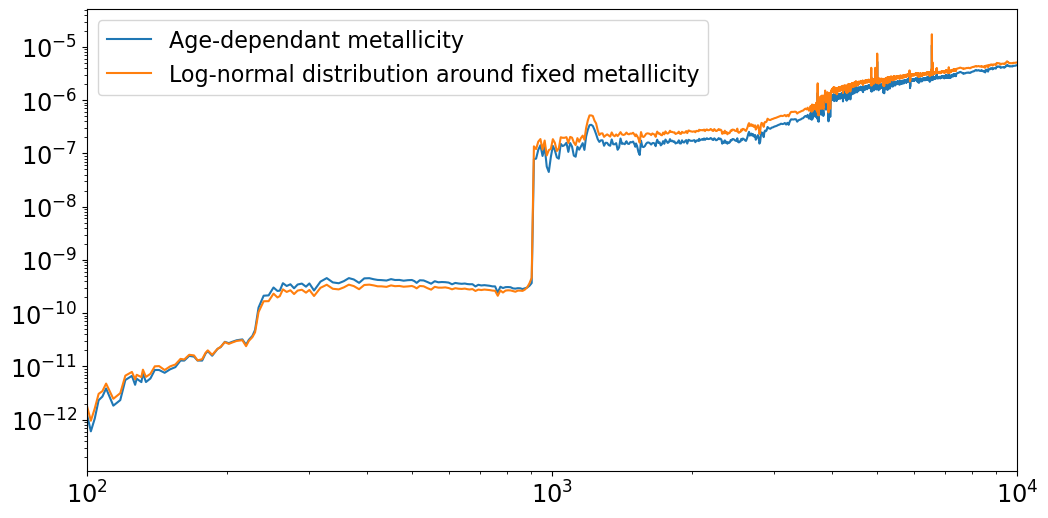

In [31]:
plt.semilogy(wave, rest, label="Age-dependant metallicity")
plt.semilogy(wave_ref, rest_ref, label="Log-normal distribution around fixed metallicity")
plt.xlim(100., 10000)
plt.xscale('log')
plt.legend()